합성곱 신경망은 출처에 따라서 합성곱 층을 부르는 단위가 다름

1. 첫번째 표기 방법

    합성곱(nn.Cov2d) + 활성화 함수(nn.ReLU)를 하나의 합성곱 층으로 보고, 맥스풀링(nn.MaxPoold2d)은 풀링 층으로 별도로 명명

2. 두번째 표기 방법

    합성곱(nn.Conv2d) + 활성화 함수(nn.ReLU) + 맥스풀링(nn.MaxPoold2d)을 하나의 합성곱 층으로 봄.


편의를 위해 맥스풀링까지도 포함해서 하나의 합성곱 층으로 판단하고 정리(두번째 표기법 선택)

In [ ]:
#ex.총 3개의 층으로 구성된 모델..
'''
# 1번 레이어 : 합성곱층(Convolutional layer)
합성곱(in_channel = 1, out_channel = 32, kernel_size=3, stride=1, padding=1) + 활성화 함수 ReLU
맥스풀링(kernel_size=2, stride=2))

# 2번 레이어 : 합성곱층(Convolutional layer)
합성곱(in_channel = 32, out_channel = 64, kernel_size=3, stride=1, padding=1) + 활성화 함수 ReLU
맥스풀링(kernel_size=2, stride=2))

# 3번 레이어 : 전결합층(Fully-Connected layer)
특성맵을 펼친다. # batch_size × 7 × 7 × 64 → batch_size × 3136
전결합층(뉴런 10개) + 활성화 함수 Softmax
'''

In [ ]:
#import
import torch
import torch.nn as nn

#임의의 텐서 만들기
#배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print('텐서의 크기 : {}'.format(inputs.shape))


텐서의 크기 : torch.Size([1, 1, 28, 28])


## 합성곱층과 풀링 선언하기

In [ ]:
#첫번째 합성곱층
conv1 = nn.Conv2d(1, 32, 3, padding = 1) #1채널 입력 -> 32채널 출력. 커널사이즈 = 3. 패딩=1
print(conv1)

#두번째 합성곱층
conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding =1)
print(conv2)

#maxpooling
#정수 하나를 인자로 넣으면 커널 사이즈와 스트라이드가 둘 다 해당값으로 지정됨.
pool = nn.MaxPool2d(2)
print(pool)


Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


## 구현체를 연결하여 모델만들기

In [ ]:
out = conv1(inputs)
print(out.shape) #크기 보존됨

torch.Size([1, 32, 28, 28])


In [ ]:
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [ ]:
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [ ]:
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


이 텐서를 펼치는 작업을 할 겁니다. 그런데 펼치기에 앞서 텐서의 n번째 차원을 접근하게 해주는 .size(n)에 대해서 배워보겠습니다. 현재 out의 크기는 1 × 64 × 7 × 7

In [ ]:
#out의 1st dimension
print(out.size(0))
print(out.size(1))
print(out.size(2))
print(out.size(3))

1
64
7
7


이제 이를 가지고 .view()를 사용하여 텐서를 펼치는 작업을 해보겠습니다.

In [ ]:
# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3136])


배치 차원을 제외하고 모두 하나의 차원으로 통합된 것을 볼 수 있습니다. 이제 이에 대해서 전결합층(Fully-Connteced layer)를 통과시켜보겠습니다. 출력층으로 10개의 뉴런을 배치하여 10개 차원의 텐서로 변환합니다.

In [ ]:
fc = nn.Linear(3136, 10) # input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape) #([1,10]) 1: 배치 차원

torch.Size([1, 10])


# CNN으로 MNIST 분류하기

In [5]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [6]:
#GPU를 사용 가능하다면 device 값이 cuda가 되고, 아니라면 cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cpu


In [7]:
#학습에 사용할 파라미터 설정
learning_rate = 0.001
training_epochs = 15
batch_size = 100

데이터셋 정의

In [17]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 받아온 MNISTdata를 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

Using downloaded and verified file: MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



데이터로더 사용해서 배치크기 지정!

In [18]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

클래스로 모델 설계
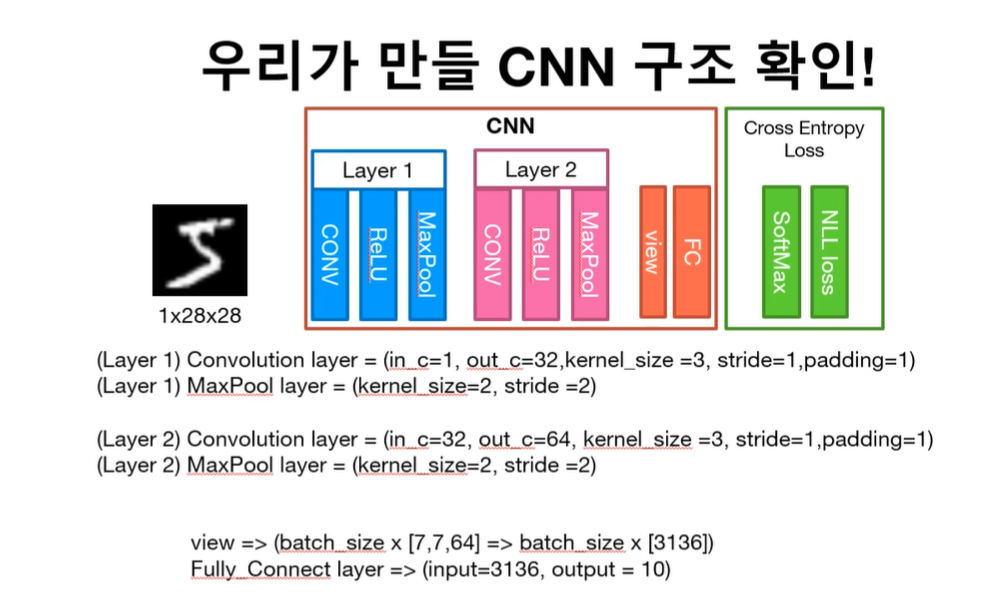

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #첫번째 convoluntion layer
    # ImgIn shape=(?,1, 28, 28): ?=batch size
    #    Conv     -> (?,32, 28, 28)
    #    Pool     -> (?,32, 14, 14)
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride =2) # <=> torch.nn.MaxPool2d(2)
    )

    #두번째 convoluntion layer
    # ImgIn shape=(?, 32, 14, 14)
    #    Conv      ->(?, 64, 14, 14)
    #    Pool      ->(?, 64, 7, 7)
    self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
    # 전결합층(Fully Connected Layer) 7(w)x7(h)x64(channel_num) inputs -> 10 outputs
    self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

    # 전결합층 한정으로 가중치 초기화
    torch.nn.init.xavier_uniform_(self.fc.weight)

  def forward(self, x): #input x(tensor): (batch_num, channel_num, w, h)
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out


모델 정의

In [ ]:
if device == 'cuda':
  model = CNN().to(device)
else:
  model = CNN()

print(model)

비용 함수와 옵티마이저 정의

In [19]:
if device == 'cuda':
  criterion = torch.nn.CrossEntropyLoss().to(device) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
else:
  criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [20]:
total_batch = len(data_loader)
print(total_batch)

600


Training

In [ ]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치 (이미지), Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X#.to(device)
        Y = Y#.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
print("Learning Finished")

TEST

In [ ]:
with torch.no_grad():
  x_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float()#.to(device)
  y_test = mnist_test.test_labels#.to(device)

  prediction = model(x_test)
  correct_prediction = torch.argmax(prediction, axis=1) == y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())




# TEST Data에서 예측 틀린 것 모으기

torch.Size([1, 1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


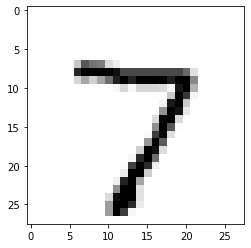

torch.Size([1, 10])
tensor([7])
141


In [ ]:
# x = mnist_test.test_data[0:2] #torch.Size([2, 28, 28])
# print(x.shape)
# plt.imshow(x.view(28, 28), cmap='Greys', interpolation='nearest')
# plt.show()
import matplotlib.pyplot as plt

x = mnist_test.test_data[0].view(-1, 1, 28, 28).float()
print(x.shape)
plt.imshow(x.view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()
prediction = model(x)
print(prediction.shape)
print(torch.argmax(prediction, axis = 1))

#틀린 데이터만 모으기
wrong_result = []
for n in range(0, len(y_test)):
  x = mnist_test.test_data[n].view(-1, 1, 28, 28).float()
  prediction = model(x)
  if torch.argmax(prediction, axis=1) != y_test[n]:
    wrong_result.append(n)

print(len(wrong_result))

Test data에서 틀린 데이터 141개 중 16개 어떤 손글씨인지 보기

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


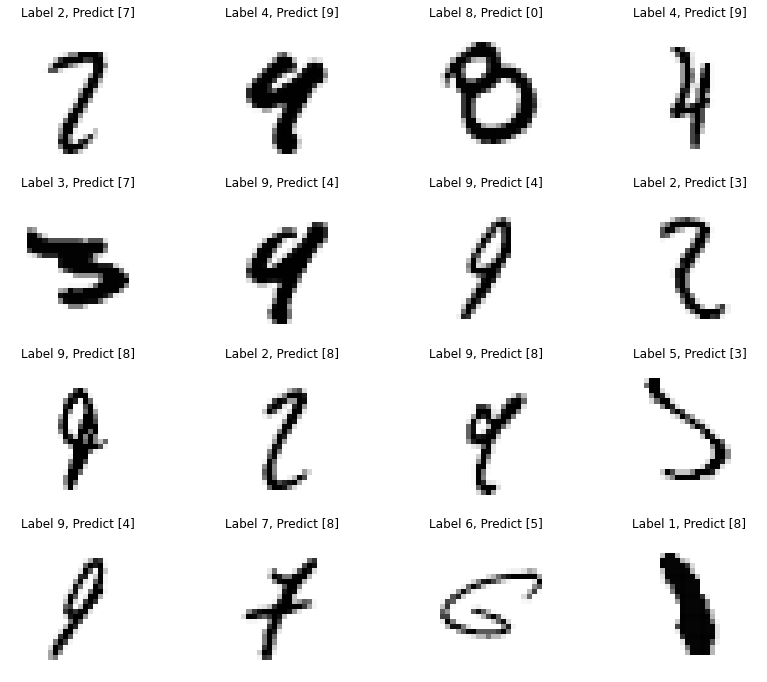

In [ ]:
import random

samples = random.choices(population=wrong_result, k = 16)

plt.figure(figsize = (14,12))

for index, n in enumerate(samples): #index:0-15, n: wrong_result에 저장된 틀린 test_data의 인덱스
  plt.subplot(4,4, index+1)
  plt.imshow(mnist_test.test_data[n].reshape(28,28), cmap = 'Greys' , interpolation='nearest')
  x = mnist_test.test_data[n].view(-1, 1, 28, 28).float()
  prediction = model(x)
  predicted_labels = torch.argmax(prediction, axis=1)
  plt.title('Label ' + str(mnist_test.test_labels[n].numpy()) + ', Predict ' + str(predicted_labels.numpy()))
  plt.axis('off')




# matplotlib로 reshape해도 모양은 그대로인지 확인하기

(batch_size, 1, 28,28) -> (batch_size, 28, 28, 1)

In [ ]:
x_single_data = mnist_test.test_data[0:1]
k = mnist_test.test_data[0]
print(k)
print(k.shape)
print(x_single_data)
print(x_single_data.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Label:  7


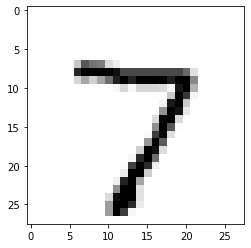

In [ ]:

x_single_data = mnist_test.test_data[0:1]
y_single_data = mnist_test.test_labels[0:1]

print('Label: ', y_single_data.item())

plt.imshow(x_single_data.view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

torch.Size([28, 28, 1])
Label:  7


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


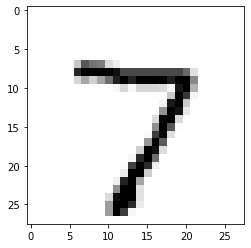

In [ ]:
x_reshaped_single_data = mnist_test.test_data[0:1].reshape(28,28,1)
print(x_reshaped_single_data.shape)
y_single_data = mnist_test.test_labels[0:1]

print('Label: ', y_single_data.item())

plt.imshow(x_reshaped_single_data.view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

# 더 깊게 레이어를 쌓으면 어떻게 될까?

-> 깊은 것보다 효율적으로 쌓는 것이 중요!!!


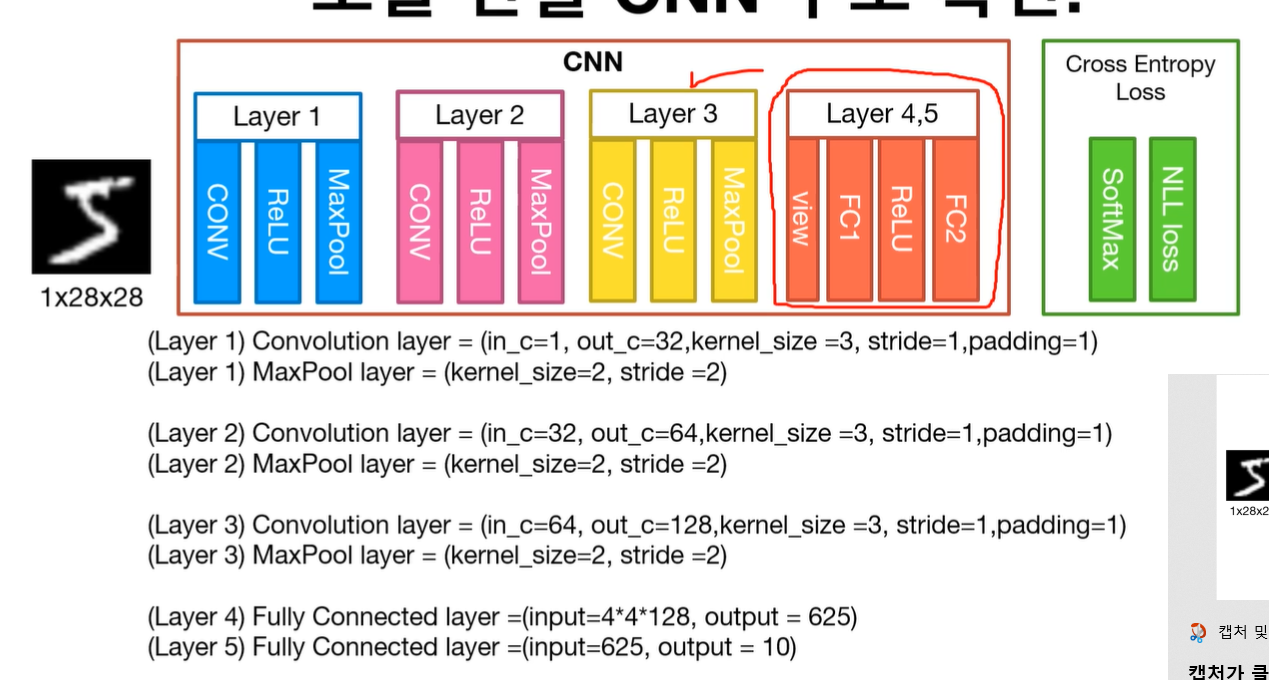

In [14]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #dropout 비율
    self.keep_prob = 0.5

    #첫번째 convoluntion layer
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride =2) # <=> torch.nn.MaxPool2d(2)
    )

    #두번째 convoluntion layer
    self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
    
    #세번째 convoluntion layer
    self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
    
    # 전결합층(Fully Connected Layer)
    self.fc1 = torch.nn.Linear(3*3*128, 625, bias = True)
    self.layer4 = torch.nn.Sequential(
        self.fc1,
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 1 - self.keep_prob)
    )
    self.fc2 = torch.nn.Linear(625, 10, bias=True)

    # 전결합층 한정으로 가중치 초기화
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self, x): #input x(tensor): (batch_num, channel_num, w, h)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.layer4(out)
        out = self.fc2(out)
        return out


In [15]:
model = CNN()
#print(model)

#model문제 없는지 값 넣어서 test
#예를 들어 모델안에서 size miss없는 지 확인
value = torch.Tensor(1,1,28,28)
print(model(value).shape)

torch.Size([1, 10])


In [21]:
#Training
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치 (이미지), Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X#.to(device)
        Y = Y#.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
print("Learning Finished")

[Epoch:    1] cost = 0.192676395
[Epoch:    2] cost = 0.0495194271
[Epoch:    3] cost = 0.034188889
[Epoch:    4] cost = 0.0273064505
[Epoch:    5] cost = 0.0237808228
[Epoch:    6] cost = 0.0209792033
[Epoch:    7] cost = 0.014999561
[Epoch:    8] cost = 0.0137875201
[Epoch:    9] cost = 0.0113369487
[Epoch:   10] cost = 0.0103568761
[Epoch:   11] cost = 0.0100209387
[Epoch:   12] cost = 0.00890113879
[Epoch:   13] cost = 0.00897316262
[Epoch:   14] cost = 0.00660326285
[Epoch:   15] cost = 0.00701807626
Learning Finished


In [22]:
#Test
with torch.no_grad():
  x_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float()#.to(device)
  y_test = mnist_test.test_labels#.to(device)

  prediction = model(x_test)
  correct_prediction = torch.argmax(prediction, axis=1) == y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9819999933242798
